In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sber_data = pd.read_csv('data/sber_data.csv', sep=',')

# Дубликаты

Иногда данные могут содержать повторяющиеся записи (дубликаты).

Дубликатами называются записи, для которых значения (всех или большинства) признаков совпадают. 

Мы уже сталкивались с такой проблемой, когда рассматривали датасет с информацией о фильмах и их рейтингах. В двух таблицах с рейтингами возникали дубликаты, из-за которых мы не могли правильно объединить данные. 

В том случае дубликаты было очень просто найти: это была последняя строка первой и первая строка второй таблиц. Но так бывает не всегда. Иногда дубликаты тщательно скрываются в данных и необходимо приложить немало усилий, чтобы их отыскать.

# Чем опасны дубликаты?

Способ обнаружения дубликатов зависит от того, что именно вы считаете дубликатом. Например, за дубликаты можно посчитать записи, у которых совпадают все признаки или их часть. Если в таблице есть столбец с уникальным идентификатором (id), вы можете попробовать поискать дубликаты по нему: одинаковые записи могут иметь одинаковый id.

✍️ Проверим, есть у нас такие записи: для этого сравним число уникальных значений в столбце id с числом строк. Число уникальных значений вычислим с помощью метода nunique():

In [3]:
sber_data['id'].nunique() == sber_data.shape[0]

True

Вроде бы всё в порядке: каждой записи в таблице соответствует свой уникальный идентификатор. Но это ещё не означает, что в таблице нет дубликатов!

Столбец с id задаёт каждой строке свой уникальный номер, поэтому сама по себе каждая строка является уникальной. Однако содержимое других столбцов может повторяться.

Чтобы отследить дубликаты, можно воспользоваться методом duplicated(), который возвращает булеву маску для фильтрации. Для записей, у которых совпадают признаки, переданные методу, он возвращает True, для остальных — False.

У метода есть параметр subset — список признаков, по которым производится поиск дубликатов. По умолчанию используются все столбцы в DataFrame и ищутся полные дубликаты.

✍️ Найдём число полных дубликатов таблице sber_data. Предварительно создадим список столбцов dupl_columns, по которым будем искать совпадения (все столбцы, не включая id). 

Создадим маску дубликатов с помощью метода duplicated() и произведём фильтрацию. Результат заносим в переменную sber_duplicates. Выведем число строк в результирующем DataFrame:

In [4]:
dupl_columns = list(sber_data.columns)
dupl_columns.remove('id')

mask = sber_data.duplicated(subset=dupl_columns)
sber_duplicates = sber_data[mask]
print(f'Число найденных дубликатов: {sber_duplicates.shape[0]}')

Число найденных дубликатов: 562


Итак, 562 строки в таблице являются полными копиями других записей. Ручной поиск совпадающих строк по 30 тысячам записей был бы практически невыполним, а с помощью pandas мы быстро, а главное, легко обнаружили дублирующиеся данные!

Теперь нам необходимо от них избавиться. Для этого легче всего воспользоваться методом drop_duplicates(), который удаляет повторяющиеся записи из таблицы. 

✍️ Создадим новую таблицу sber_dedupped, которая будет версией исходной таблицы, очищенной от полных дубликатов.

In [5]:
sber_dedupped = sber_data.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {sber_dedupped.shape[0]}')

Результирующее число записей: 29909


# Неинформативные признаки

Отсутствием новой и полезной информации могут «похвастаться» не только отдельные записи в таблице, но и целые признаки.

Неинформативными называются признаки, в которых большая часть строк содержит одинаковые значения (например, пол клиентов в мужском барбершопе), либо наоборот — признак, в котором для большинства записей значения уникальны (например, номер телефона клиента). 

Мы уже сталкивались с неинформативными признаками. Вспомните датасет о домах в Мельбурне, где был признак адреса дома с уникальным значением для каждого дома. 

## Чем опасны неинформативные признаки?

Такие признаки не играют роли при моделировании и лишь засоряют таблицу, увеличивая размерность данных. Они усиливают уже знакомое нам проклятие размерности, которое увеличивает время обучения модели и потенциально может снизить ее качество. 

Поэтому от таких признаков необходимо безжалостно избавляться.

# Обнаружение и ликвидация неинформативных признаков

Чтобы считать признак неинформативным, прежде всего нужно задать какой-то определённый порог. Например, часто используют пороги в 0.95 и 0.99. Это означает: признак неинформативен, если в нем 95 % (99 %) одинаковых значений или же 95 % (99 %) данных полностью уникальны.

К сожалению, в pandas пока нет волшебной палочки, которая мгновенно бы выдавала список столбцов, обладающих низкой информативностью. Однако процедура их поиска легко реализуется вручную.

Разберём алгоритм:

→ Создаём пустой список low_information_cols, куда будем добавлять названия признаков, которые мы посчитаем неинформативными.

→ В цикле пройдёмся по всем именам столбцов в таблице и для каждого будем совершать следующие действия:

рассчитаем top_freq — наибольшую относительную частоту с помощью метода value_counts() с параметром normalize=True. Метод вернёт долю от общих данных, которую занимает каждое уникальное значение в признаке.
Например, для столбца oil_chemistry_raion (нефтехимический район) результат будет следующим:

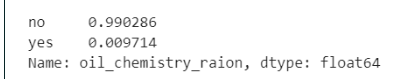

Отсюда нам нужен максимум.

рассчитаем nunique_ratio — отношение числа уникальных значений в столбце к размеру всего столбца. Число уникальных значений в столбце получим с помощью метода nunique(), а размер признака — с помощью метода count(). Например, для столбца id число уникальных значений — 30471; оно же равно размеру таблицы. Поэтому результат отношения будет 1.
сравним каждое из полученных чисел с пороговым значением (у нас это 0.95) и добавим в список неинформативных признаков, если условие истинно.

In [6]:
#список неинформативных признаков
low_information_cols = [] 

#цикл по всем столбцам
for col in sber_data.columns:
    #наибольшая относительная частота в признаке
    top_freq = sber_data[col].value_counts(normalize=True).max()
    #доля уникальных значений от размера признака
    nunique_ratio = sber_data[col].nunique() / sber_data[col].count()
    # сравниваем наибольшую частоту с порогом
    if top_freq > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(top_freq*100, 2)}% одинаковых значений')
    # сравниваем долю уникальных значений с порогом
    if nunique_ratio > 0.95:
        low_information_cols.append(col)
        print(f'{col}: {round(nunique_ratio*100, 2)}% уникальных значений')

id: 100.0% уникальных значений
oil_chemistry_raion: 99.03% одинаковых значений
railroad_terminal_raion: 96.27% одинаковых значений
nuclear_reactor_raion: 97.17% одинаковых значений
big_road1_1line: 97.44% одинаковых значений
mosque_count_1000: 98.08% одинаковых значений


Итак, мы нашли шесть неинформативных признаков. Теперь можно удалить их с помощью метода drop(), передав результирующий список в его аргументы.

In [7]:
information_sber_data = sber_data.drop(low_information_cols, axis=1)
print(f'Результирующее число признаков: {information_sber_data.shape[1]}')

Результирующее число признаков: 55


# Примечание

Однако всегда следует скептически относиться к результатам, которые предоставил алгоритм поиска неинформативных признаков. В противном случае можно лишиться важных данных. 

Например, в ваших данных есть признак цены акций, которая всё время меняется. В каждый момент времени её цена уникальна, то есть число уникальных значений в столбце совпадает с размером столбца. Казалось бы, по критерию информативности это кандидат на выбывание, но если мы рассматриваем задачу предсказания спроса на эти самые акции, то очевидно, что цена — это очень важный фактор, несмотря на свою уникальность. Именно цена на акции определяет спрос на них.

Могут возникнуть ситуации, когда присутствует огромная разница в частотах для каждого уникального значения в столбце, но это вовсе не значит, что признак неинформативен. Например, у нас могут быть данные о различных переводах между счетами пользователей. В этих данных может быть очень важный признак мошенничества (два возможных значения — да и нет). Как правило, соотношение между мошенниками и обычными пользователями около — 2/98 % (мошенников 1-2 %, а обычных пользователей — 98-99 %). Но стоит ли удалять данный признак из данных зависит от поставленной перед нами задачи.

Будьте внимательны и рассудительны при поиске неинформативных признаков. Лучшее решение — для начала использовать все признаки для построения базовой модели, а затем уже выбирать те, которые обладают наибольшей информативностью.

Более подробно мы рассмотрим данные нюансы в блоке по машинному обучению.

# Важность признаков

На самом деле информативность признаков определяется не только числом уникальных значений, но и их влиянием на целевой признак (тот, который мы хотим предсказать). Это называется важностью признака. 

Признаки, которые обладают низкой важностью, называют нерелевантными признаками. 

Например, если бы в наших данных о квартирах был признак, содержащий информацию о температуре воздуха за окном, он был бы нерелевантным.

Нерелевантные признаки могут быть не такими очевидными. В таких случаях применяются более сложные способы их поиска с использованием статистики и моделей машинного обучения. Мы поговорим об этом позже, когда вплотную подойдём к Machine Learning.

Мы рассмотрели методы поиска данных, которые не несут полезной информации и поэтому подлежат исключению. Давайте проверим, как вы усвоили материал ↓